# Parametric shape optimization with differentiable FEM simulation


## Setup

In [1]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [2]:
# import tesseract_core

# tesseract_core.build_tesseract("sdf_fd_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

In [1]:
# The PyMAPDL Host (X.X.X.X IP Address) and Port (XXX) are pulled from the environment
import os

HOST = os.getenv("MAPDL_HOST")
HOST = "172.26.3.35"
if HOST is None:
    raise ValueError(
        "Unable to read $MAPDL_HOST from the environment. "
        + "Use 'export MAPDL_HOST=X.X.X.X' for local IP address of your MAPDL Instance."
    )
PORT = os.getenv("MAPDL_PORT")
PORT = "50052"
if PORT is None:
    raise ValueError(
        "Unable to read $MAPDL_PORT from the environment. "
        + "Use 'export MAPDL_PORT=X' for the port of your MAPDL Instance."
    )

## Design Space Tesseract

In [ ]:
import imageio
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference
from utils import (
    MMAOptimizer,
    hex_grid,
    hex_to_pyvista,
    plot_grid,
    plot_grid_slice,
    plot_mesh,
)

from tesseract_jax import apply_tesseract

In [ ]:
design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
# design_tess = Tesseract.from_image("sdf_fd_tess")
# design_tess.serve()
stl_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [ ]:
n_chains = 2
n_edges_per_chain = 3
bar_radius = 1.2

Lx, Ly, Lz = 20.0, 5.0, 10.0
Nx, Ny, Nz = 64, 16, 32

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 2].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

initial_params = initial_params.flatten()

normalization_factors = jnp.ones_like(initial_params, dtype=jnp.float32) * 0.1
initial_params = initial_params * normalization_factors
normalization_bias = jnp.zeros_like(initial_params, dtype=jnp.float32)


design_inputs = {
    "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
    "static_parameters": [n_chains, n_edges_per_chain + 1],
    "string_parameters": [],
    "mesh_tesseract": TesseractReference(stl_tess),
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "epsilon": 0.001,  # epsilon, only used for FD of the jacobian
    "grid_center": [0.0, 0.0, 0.0],
    "max_points": 2000,
    "max_faces": 4000,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "normalize_jacobian": False,
    "precompute_jacobian": False,
    "sdf_backend": "pyvista",
}

design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Number of vertices: 202
Number of faces: 400
SDF shape: (64, 16, 32)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

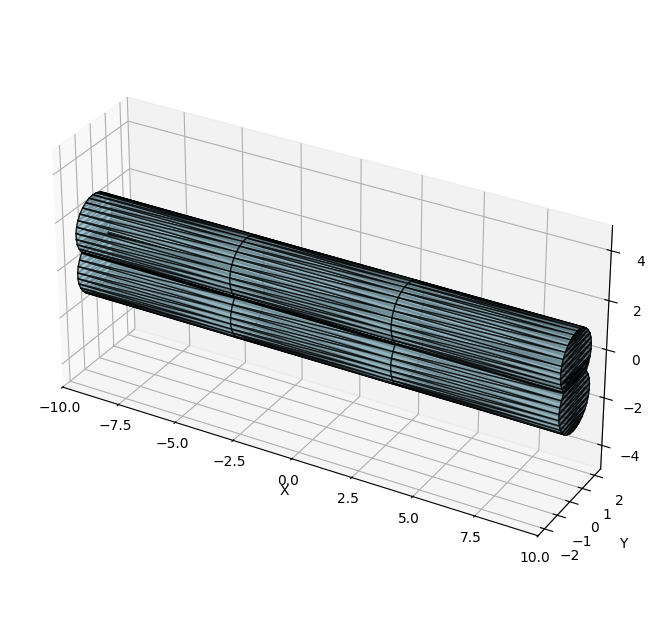

In [12]:
plot_mesh(mesh, [Lx, Ly, Lz])

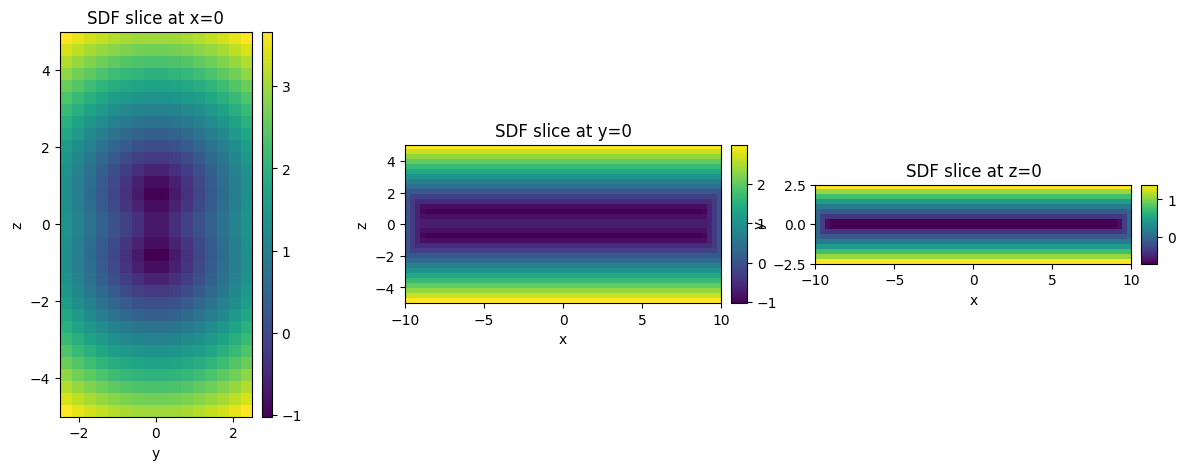

In [13]:
plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz, "SDF")

In [14]:
result = design_tess.jacobian(
    inputs={
        "differentiable_parameters": initial_params,
        **design_inputs,
    },
    jac_inputs=["differentiable_parameters"],
    jac_outputs=["sdf"],
)

Computing Jacobian...


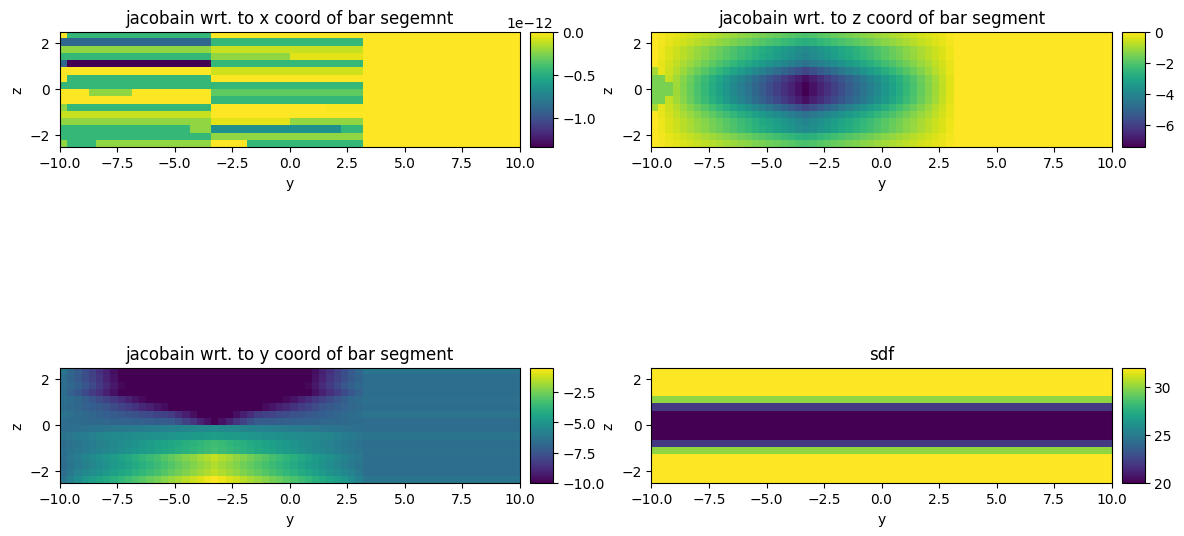

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][3], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 0],
    title="jacobain wrt. to x coord of bar segemnt",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][4], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 0],
    title="jacobain wrt. to y coord of bar segment",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][5], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="jacobain wrt. to z coord of bar segment",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.sum(sdf > 0, 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 1],
    title="sdf",
    xlabel="y",
    ylabel="z",
)

## Density Variation

rho min: 0.0007239776896312833, rho max: 0.8956337571144104


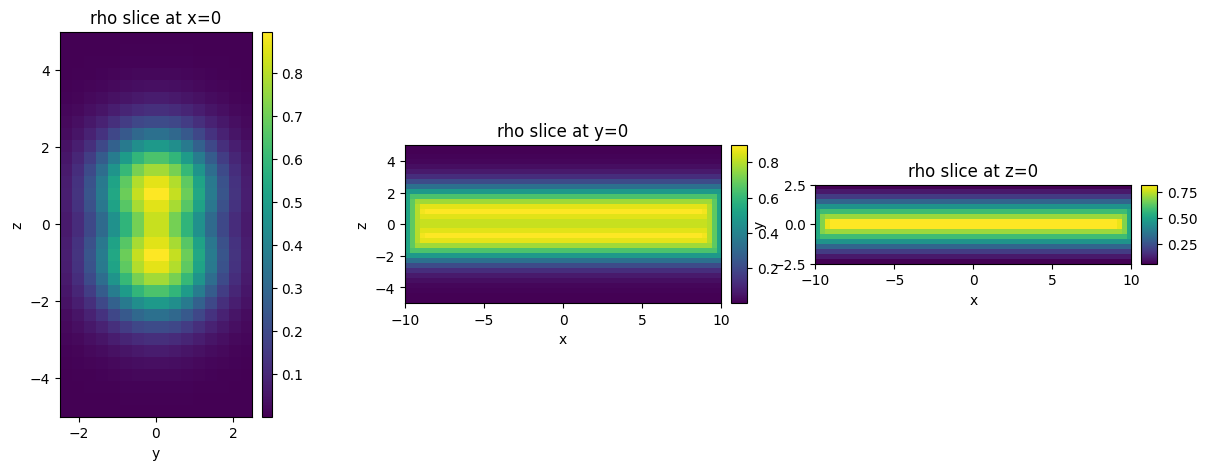

In [16]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho = sdf_to_rho(sdf, scale=2)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

## Hex Mesh

In [17]:
points, cells = hex_grid(Lx, Ly, Lz, Nx + 1, Ny + 1, Nz + 1)

hex_mesh = {
    "points": points,
    "faces": cells,
    "n_points": jnp.array(points.shape[0]),
    "n_faces": jnp.array(cells.shape[0]),
}

Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [18]:
pv_mesh = hex_to_pyvista(
    hex_mesh["points"],
    hex_mesh["faces"],
    {"rho": rho.flatten()},
)

print(pv_mesh)

pv_mesh.save("tmp_vtks/bars_mesh.vtk")

UnstructuredGrid (0x7986bef08a60)
  N Cells:    32768
  N Points:   36465
  X Bounds:   -1.000e+01, 1.000e+01
  Y Bounds:   -2.500e+00, 2.500e+00
  Z Bounds:   -5.000e+00, 5.000e+00
  N Arrays:   1


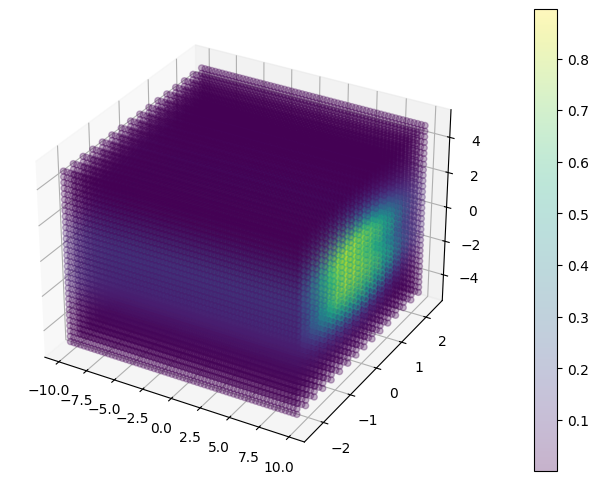

In [19]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = rho.flatten()
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    alpha=0.3,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

## Boundary Conditions

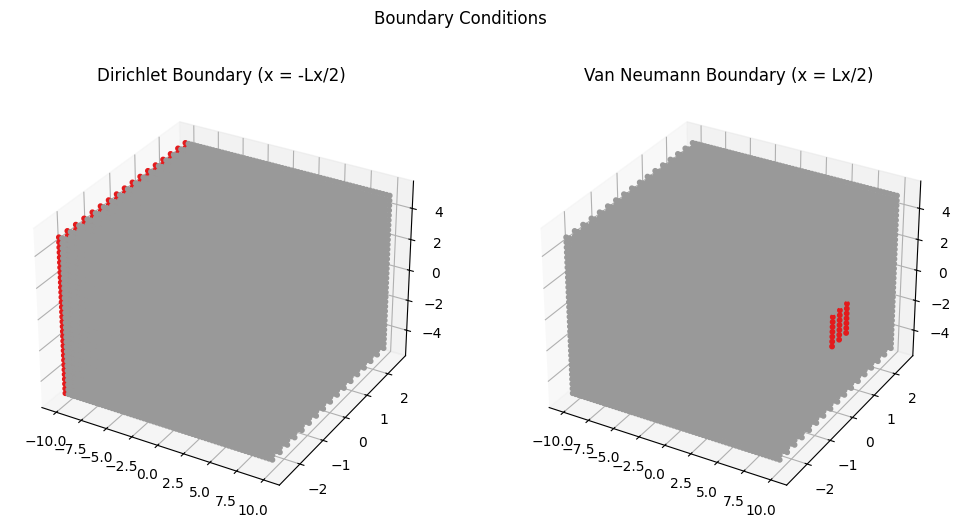

In [20]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Ly: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Ly: Size of the domain in y-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2
    # von Neumann condition (select nodes at x=Lx with constraints on y and z)
    x_lim = Lx / 2
    y_min = -0.1 * Ly
    y_max = 0.1 * Ly
    z_min = -0.1 * Lz
    z_max = 0.1 * Lz
    van_neumann_mask = jnp.logical_and(
        hex_mesh["points"][:, 0] >= x_lim,
        jnp.logical_and(
            jnp.logical_and(
                hex_mesh["points"][:, 1] >= y_min, hex_mesh["points"][:, 1] <= y_max
            ),
            jnp.logical_and(
                hex_mesh["points"][:, 2] >= z_min, hex_mesh["points"][:, 2] <= z_max
            ),
        ),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(hex_mesh, Lx, Ly, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
pts = hex_mesh["points"]
axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask, 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask, 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

## Finite Element Analysis

In [23]:
# load the Finite Element Method Tesseract
# fem_tess = Tesseract.from_tesseract_api("pymapdl_tess/tesseract_api.py")
fem_tess = Tesseract.from_image("pymapdl_tess")
fem_tess.serve()

In [24]:
# TODO unify this framework
dirichlet_idx = jnp.where(dirichlet_mask)[0]
von_neumann_idx = jnp.where(van_neumann_mask)[0]
von_neumann_values = jnp.array([0, 0.0, 0.1]) + jnp.zeros((von_neumann_idx.shape[0], 3))

c = apply_tesseract(
    fem_tess,
    {
        "dirichlet_mask": dirichlet_idx,
        "dirichlet_values": jnp.zeros(dirichlet_idx.size),
        "van_neumann_mask": von_neumann_idx,
        "van_neumann_values": von_neumann_values,
        "hex_mesh": hex_mesh,
        "host": HOST,
        "port": PORT,
        "rho": jnp.expand_dims(rho.flatten(), axis=-1),
        "E0": 1.0,
        "rho_min": 1e-6,
        "log_level": "DEBUG",
        "vtk_output": "mesh_density.vtk",
    },
)["compliance"]

print(f"Compliance: {c:.4f}")

Compliance: 3282.4985


## Optimization Setup

In [25]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [36]:
def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    # params = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {"differentiable_parameters": params.flatten(), **design_inputs},
    )

    sdf = design_out["sdf"]
    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=2)
    rho_grid = identity_and_store_grads(rho_grid, iteration + 2000)

    # calculate BCs
    dirichlet_mask, van_neumann_mask = get_boundary_masks(hex_mesh, Lx, Ly, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    # dirichlet_values = jnp.array([0.0])
    # van_neumann_values = jnp.array([[0.0, 0.0, 0.1]])

    # TODO unify this framework
    dirichlet_idx = jnp.where(dirichlet_mask)[0]
    von_neumann_idx = jnp.where(van_neumann_mask)[0]
    von_neumann_values = jnp.array([0, 0.0, 0.1]) + jnp.zeros(
        (von_neumann_idx.shape[0], 3)
    )

    c = apply_tesseract(
        fem_tess,
        {
            "dirichlet_mask": dirichlet_idx,
            "dirichlet_values": jnp.zeros(dirichlet_idx.size),
            "van_neumann_mask": von_neumann_idx,
            "van_neumann_values": von_neumann_values,
            "hex_mesh": hex_mesh,
            "host": HOST,
            "port": PORT,
            "rho": jnp.expand_dims(rho_grid.flatten(), axis=-1),
            "E0": 1.0,
            "rho_min": 1e-6,
            "log_level": "WARNING",
            "vtk_output": None,
        },
    )["compliance"]

    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    return c, {"sdf": sdf, "rho_grid": rho_grid, "surface_mesh": surface_mesh}


grad_fn = jax.value_and_grad(loss, has_aux=True)

## Lets have a look at the gradients

In [37]:
(loss_value, aux), grads = grad_fn(initial_params, iteration=0)
print(f"loss {loss_value}, grads {grads}")

JaxRuntimeError: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/anaconda/envs/fem/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 758, in start
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 211, in start
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 683, in run_forever
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 2050, in _run_once
  File "/anaconda/envs/fem/lib/python3.13/asyncio/events.py", line 89, in _run
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 701, in shell_main
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 469, in dispatch_shell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 379, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 899, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 471, in do_execute
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 632, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
  File "/tmp/ipykernel_25210/616014104.py", line 1, in <module>
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 502, in value_and_grad_f
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 2194, in _vjp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 315, in vjp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 287, in linearize
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 255, in direct_linearize
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 212, in call_wrapped
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api_util.py", line 106, in flatten_fun_nokwargs2
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api_util.py", line 292, in _argnums_partial
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 421, in _get_result_paths_thunk
  File "/tmp/ipykernel_25210/585734000.py", line 43, in loss
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 384, in apply_tesseract
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 632, in bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 924, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 1135, in fallback_linearize_rule
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 1169, in linearize_from_jvp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 212, in call_wrapped
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 421, in _get_result_paths_thunk
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 126, in tesseract_dispatch_jvp_rule
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 632, in bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/partial_eval.py", line 224, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/partial_eval.py", line 233, in default_process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 1189, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/dispatch.py", line 94, in apply_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 263, in cache_miss
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 146, in _python_pjit_helper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 1622, in _pjit_call_impl_python
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/profiler.py", line 359, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/pxla.py", line 1371, in __call__
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/callback.py", line 784, in _wrapped_callback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 208, in _dispatch
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/tesseract_compat.py", line 160, in apply
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 35, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 325, in apply
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 619, in run_tesseract
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 539, in _request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/api.py", line 59, in request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/sessions.py", line 589, in request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/sessions.py", line 703, in send
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/adapters.py", line 708, in send
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connectionpool.py", line 864, in urlopen
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connectionpool.py", line 535, in _make_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connection.py", line 565, in getresponse
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 1447, in getresponse
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 331, in begin
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 292, in _read_status
  File "/anaconda/envs/fem/lib/python3.13/socket.py", line 723, in readinto
KeyboardInterrupt: 

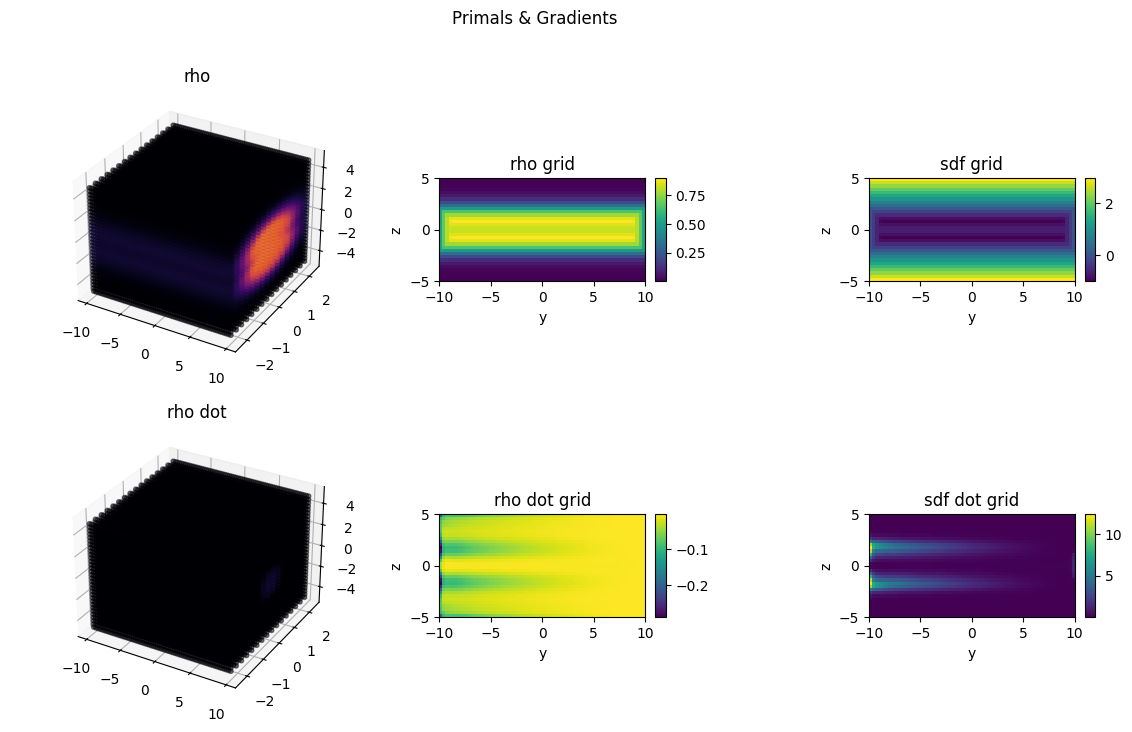

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
plt.suptitle("Primals & Gradients")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

ax = axs[0, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

ax = axs[1, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

# Set the first two subplots to 3D
axs[0, 0] = fig.add_subplot(2, 2, 1, projection="3d")
axs[1, 0] = fig.add_subplot(2, 2, 3, projection="3d")


mesh = hex_mesh

pts_coords = mesh["points"]
hex_cells = mesh["faces"]
pts = jnp.mean(pts_coords[hex_cells], axis=1)

axs[0, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=aux["rho_grid"],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[0, 0].set_title("rho")

axs[1, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=-grad_storage[2000][1],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[1, 0].set_title("rho dot")

plot_grid_slice(
    aux["rho_grid"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 1],
    title="rho grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[2000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 1],
    title="rho dot grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    aux["sdf"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 2],
    title="sdf grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[1000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 2],
    title="sdf dot grid",
    xlabel="y",
    ylabel="z",
)

fig.subplots_adjust(wspace=0.9)

### Finite difference check

In [ ]:
params = initial_params.copy()

(loss_value, aux), grads = grad_fn(params, iteration=0)

# Finite difference check
run_central_difference = False
num_tests = 3
FD_delta = 1.0e-4
FD_grads = 0 * jnp.array(grads)
for i in range(num_tests):
    print(i)
    params_up = params.at[i].add(FD_delta)
    (fupp, _), _ = grad_fn(params_up, iteration=i * 2)

    if run_central_difference:
        params_down = params.at[i].subtract(2.0 * FD_delta)
        (fdown, _), _ = grad_fn(params_down, iteration=i * 2 + 1)
        FD_grads = FD_grads.at[i].set((fupp - fdown) / FD_delta / 2.0)

    else:
        FD_grads = FD_grads.at[i].set((fupp - loss_value) / FD_delta)

if num_tests > 0:
    sens = jnp.array(grads[0:num_tests])
    FD_sens = FD_grads[0:num_tests]
    print(sens)
    print(FD_sens)
    errors = sens - FD_sens
    print(errors)
    rel_abs_error = jnp.abs(errors / sens)
    if run_central_difference:
        print(f"Relative error should be near O({FD_delta})")
    else:
        print(f"Relative error should be O({FD_delta * 10})")
    print(rel_abs_error)

JaxRuntimeError: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/anaconda/envs/fem/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 758, in start
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 211, in start
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 683, in run_forever
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 2050, in _run_once
  File "/anaconda/envs/fem/lib/python3.13/asyncio/events.py", line 89, in _run
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 701, in shell_main
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 469, in dispatch_shell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 379, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 899, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 471, in do_execute
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 632, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
  File "/tmp/ipykernel_25210/3839981593.py", line 3, in <module>
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 502, in value_and_grad_f
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 2194, in _vjp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 315, in vjp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 287, in linearize
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 255, in direct_linearize
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 212, in call_wrapped
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api_util.py", line 106, in flatten_fun_nokwargs2
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api_util.py", line 292, in _argnums_partial
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 421, in _get_result_paths_thunk
  File "/tmp/ipykernel_25210/50847115.py", line 43, in loss
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 384, in apply_tesseract
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 632, in bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 924, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 1135, in fallback_linearize_rule
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 1169, in linearize_from_jvp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 212, in call_wrapped
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 421, in _get_result_paths_thunk
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 126, in tesseract_dispatch_jvp_rule
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 632, in bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/partial_eval.py", line 224, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/partial_eval.py", line 233, in default_process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 1189, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/dispatch.py", line 94, in apply_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 263, in cache_miss
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 146, in _python_pjit_helper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 1622, in _pjit_call_impl_python
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/profiler.py", line 359, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/pxla.py", line 1371, in __call__
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/callback.py", line 784, in _wrapped_callback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 208, in _dispatch
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/tesseract_compat.py", line 160, in apply
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 35, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 325, in apply
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 619, in run_tesseract
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 539, in _request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/api.py", line 59, in request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/sessions.py", line 589, in request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/sessions.py", line 703, in send
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/adapters.py", line 708, in send
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connectionpool.py", line 864, in urlopen
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connectionpool.py", line 535, in _make_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connection.py", line 565, in getresponse
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 1447, in getresponse
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 331, in begin
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 292, in _read_status
  File "/anaconda/envs/fem/lib/python3.13/socket.py", line 723, in readinto
KeyboardInterrupt: 

## Design Optimization using MMA

In [38]:
n_steps = 20

# set design bounds by a perturbation value 'delta'
delta_x = 0.0
delta_y = 0.0
delta_z = Lz / 3
eps = 1.0e-3  # a small value to ease numerics
bar_params = jnp.array(initial_params).reshape(n_chains, n_edges_per_chain + 1, 3)
param_min = bar_params - eps
param_max = bar_params + eps
for bar_idx, bar in enumerate(bar_params):
    for coord_idx, _xyz in enumerate(bar):
        for i, delta in enumerate([delta_x, delta_y, delta_z]):
            param_min = param_min.at[bar_idx, coord_idx, i].add(-delta)
            param_max = param_max.at[bar_idx, coord_idx, i].add(delta)

param_min = param_min.flatten().at[:, None].get()
param_max = param_max.flatten().at[:, None].get()

# A placeholder is used for constraint
num_constraints = 0
g = jnp.zeros((0, 1))
dgdx = jnp.zeros((0, initial_params.shape[0]))

# initialize the optimizer
x_update_limit = 0.005
params = initial_params.copy()
loss_hist = []
params_hist = []
aux_hist = []
optimizer = MMAOptimizer(
    initial_params[:, None],
    param_min,
    param_max,
    num_constraints,
    x_update_limit=x_update_limit,
)


for i in range(n_steps):
    (loss_value, aux), grads = grad_fn(params, iteration=i)
    print(loss_value)
    print(params)
    print(grads)
    np_params = optimizer.calculate_next_x(loss_value, grads, g, dgdx, i + 1, params)
    params = jnp.array(np_params.flatten())

    loss_hist.append(loss_value)
    params_hist.append(params)
    aux_hist.append(aux)

    print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
3282.4985
[-1.          0.         -0.08333334 -0.33333328  0.         -0.08333334
  0.3333334   0.         -0.08333334  1.          0.         -0.08333334
 -1.          0.          0.08333334 -0.33333328  0.          0.08333334
  0.3333334   0.          0.08333334  1.          0.          0.08333334]
[ 2.53892529e+03 -4.48005615e+03  1.03463613e+04  6.44829416e-12
 -4.49373633e+03  1.11375938e+04 -7.95398383e-12 -4.51474609e+03
  3.04153003e+03 -2.21695541e+02 -4.52166309e+03  2.09706512e+02
  2.53892505e+03 -4.48003613e+03 -1.03532949e+04 -2.52273862e-11
 -4.49374219e+03 -1.11331396e+04 -1.04306295e-11 -4.51474365e+03
 -3.05172412e+03 -2.21695541e+02 -4.52166309e+03 -2.22946548e+02]
Iteration 1, Loss: 3282.4985
Storing values in hash 2001
Storing values in hash 1001
Computing Jacobian...
2095.6873
[-1.0000100e+00  9.9992531e-06 -1.1667667e-01 -3.3333328e-01
  9.9992558e-06 -1.1667667e-01  3.3333340e-01  9.9

### Optimization Postprocess

Text(0.5, 1.0, 'Compliance over Optimization')

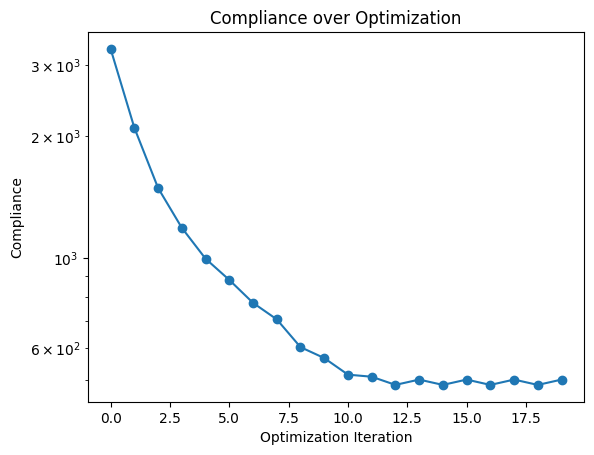

In [39]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [40]:
for i in range(n_steps):
    mesh = hex_mesh
    rho_dot = grad_storage[i + 2000][1][: len(mesh["faces"])]
    pv_mesh = hex_to_pyvista(
        mesh["points"],
        mesh["faces"],
        {"rho": aux_hist[i]["rho_grid"].T.flatten(), "rho_dot": rho_dot.T.flatten()},
    )
    pv_mesh.save(f"tmp_vtks/fem_shapeopt_mesh{i + 1}.vtk")

In [41]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    rho = aux["rho_grid"]

    im = plt.imshow((rho[:, :, :] > 0.5).sum(axis=1).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_bars_optim.gif", writer="pillow", fps=10)

In [45]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist):
    plot_mesh(
        aux["surface_mesh"],
        save_path=f"tmp_img/mesh_optim_{i:03d}.png",
        bounds=[Lx, Ly, Lz],
    )

images = []

for i in range(n_steps):
    filename = f"tmp_img/mesh_optim_{i:03d}.png"
    images.append(imageio.imread(filename))
    print(f"Added {filename} to gif.")
# make sure the gif repeats forever
imageio.mimsave("mesh_optim.gif", images, fps=10, loop=0)

/tmp/ipykernel_25210/999534671.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


Added tmp_img/mesh_optim_000.png to gif.
Added tmp_img/mesh_optim_001.png to gif.
Added tmp_img/mesh_optim_002.png to gif.
Added tmp_img/mesh_optim_003.png to gif.
Added tmp_img/mesh_optim_004.png to gif.
Added tmp_img/mesh_optim_005.png to gif.
Added tmp_img/mesh_optim_006.png to gif.
Added tmp_img/mesh_optim_007.png to gif.
Added tmp_img/mesh_optim_008.png to gif.
Added tmp_img/mesh_optim_009.png to gif.
Added tmp_img/mesh_optim_010.png to gif.
Added tmp_img/mesh_optim_011.png to gif.
Added tmp_img/mesh_optim_012.png to gif.
Added tmp_img/mesh_optim_013.png to gif.
Added tmp_img/mesh_optim_014.png to gif.
Added tmp_img/mesh_optim_015.png to gif.
Added tmp_img/mesh_optim_016.png to gif.
Added tmp_img/mesh_optim_017.png to gif.
Added tmp_img/mesh_optim_018.png to gif.
Added tmp_img/mesh_optim_019.png to gif.
